# Previous Class Definitions
The previously defined Layer_Dense, Activation_ReLU, and Activation_Softmax classes.

In [5]:
# imports
import matplotlib.pyplot as plt
import numpy as np
import nnfs
from nnfs.datasets import spiral_data, vertical_data
nnfs.init()

In [6]:
class Layer_Dense:
    def __init__(self, n_inputs, n_neurons):
        # Initialize the weights and biases
        self.weights = 0.01 * np.random.randn(n_inputs, n_neurons)  # Normal distribution of weights
        self.biases = np.zeros((1, n_neurons))

    def forward(self, inputs):
        # Calculate the output values from inputs, weights, and biases
        self.output = np.dot(inputs, self.weights) + self.biases        # Weights are already transposed

class Activation_ReLU:
    def forward(self, inputs):
        self.output = np.maximum(0, inputs)
        
class Activation_Softmax:
    def forward(self, inputs):
        # Get the unnormalized probabilities
        # Subtract max from the row to prevent larger numbers
        exp_values = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))

        # Normalize the probabilities with element wise division
        probabilities = exp_values / np.sum(exp_values, axis=1,keepdims=True)
        self.output = probabilities

# Forward Pass with No Loss Consideration
2 input neural network with 2 layers of 3 neurons each. ReLU activation in the first layer with Softmax in the second layer to normalize the outputs.

In [4]:
# Create dataset
X, y = spiral_data(samples=100, classes=3)
# Create Dense layer with 2 input features and 3 output values
dense1 = Layer_Dense(2, 3)
# Create ReLU activation (to be used with Dense layer):
activation1 = Activation_ReLU()
# Create second Dense layer with 3 input features (as we take output
# of previous layer here) and 3 output values
dense2 = Layer_Dense(3, 3)
# Create Softmax activation (to be used with Dense layer):
activation2 = Activation_Softmax()

# Make a forward pass of our training data through this layer
dense1.forward(X)

# Make a forward pass through activation function
# it takes the output of first dense layer here
activation1.forward(dense1.output)
# Make a forward pass through second Dense layer
# it takes outputs of activation function of first layer as inputs
dense2.forward(activation1.output)
# Make a forward pass through activation function
# it takes the output of second dense layer here
activation2.forward(dense2.output)
# Let's see output of the first few samples:
print(activation2.output[:5])

[[0.33333334 0.33333334 0.33333334]
 [0.33333316 0.3333332  0.33333364]
 [0.33333287 0.3333329  0.33333418]
 [0.3333326  0.33333263 0.33333477]
 [0.33333233 0.3333324  0.33333528]]


# Calculating Network Error with Categorical Cross Entropy Loss
loss = negative sum of the expected output * log(neural network output)
loss = - sum(expected_i * log(nn_output_i)) for all i in outputs

In the classification case, incorrect outputs do not end up mattering as the expected_i for the wrong class is 0.


In [6]:
nn_outputs = np.array([
    [0.7, 0.1, 0.2],
    [0.1, 0.5, 0.4],
    [0.02, 0.9, 0.08]])
class_targets = [0, 1, 1]
losses = -np.log(nn_outputs[range(len(nn_outputs)), class_targets])
print(f"Losses: {losses}")
print(f"Average Loss: {np.average(losses)}")

Losses: [0.35667494 0.69314718 0.10536052]
Average Loss: 0.38506088005216804


## Loss with One Hot Encoding
Classification typically has the expected output to be all zero except for the class the inputs belong too. This leads to simplfiying the cross entropy loss calculation.

In [7]:
true_output = np.array([
    [1, 0, 0],
    [0, 1, 0],
    [0, 1, 0]
])

nn_output = np.array([
    [0.7, 0.2, 0.1],
    [0.1, 0.5, 0.4],
    [0.02, 0.9, 0.08]
])

# Element by element multiplication "erases" the output terms corresponding with 0
A = true_output*nn_output

# Sum the columns (ie, sum every element in row 0, then row 1, etc) because each row is a batch of output
B = np.sum(A, axis = 1)

# Get the cross entropy loss
C = -np.log(B)

print(f"Losses: {C}")
print(f"Average Loss: {np.mean(C)}")


Losses: [0.35667494 0.69314718 0.10536052]
Average Loss: 0.38506088005216804


## Implementing the Loss Class

In [2]:
# Base class for Loss functions
class Loss:
    '''Calculates the data and regularization losses given
    model output and ground truth values'''
    def calculate(self, output, y):
        sample_losses = self.forward(output, y)
        data_loss = np.average(sample_losses)
        return data_loss

## Implementing the Categorical Cross Entropy Loss Class

In [3]:
class Loss_CategoricalCrossEntropy(Loss):
    def forward(self, y_pred, y_true):
        '''y_pred is the neural network output
        y_true is the ideal output of the neural network'''
        samples = len(y_pred)
        # Bound the predicted values 
        y_pred_clipped = np.clip(y_pred, 1e-7, 1-1e-7)
        
        if len(y_true.shape) == 1:     # Categorically labeled
            correct_confidences = y_pred_clipped[range(samples), y_true]
        elif len(y_true.shape) == 2:   # One hot encoded
            correct_confidences = np.sum(y_pred_clipped*y_true, axis=1)

        # Calculate the losses
        negative_log_likelihoods = -np.log(correct_confidences)
        return negative_log_likelihoods

In [17]:
nn_outputs = np.array([
    [0.7, 0.1, 0.2],
    [0.1, 0.5, 0.4],
    [0.02, 0.9, 0.08]])
class_targets = np.array([
    [1, 0, 0],
    [0, 1, 0],
    [0, 1, 0]])

loss_function = Loss_CategoricalCrossEntropy()
losses = loss_function.calculate(nn_outputs, class_targets)
print(f"Losses: {losses}")
print(f"Average Loss: {np.average(losses)}")

Losses: 0.38506088005216804
Average Loss: 0.38506088005216804


# Introducing Accuracy
In the simple example, if the highest value in the outputs align with the correct classification, then that accuracy is 1. Even if it was 51% red and 49% blue, and the true output is red, it would be considered fully accurate.

In [18]:
nn_outputs = np.array([
    [0.7, 0.1, 0.2],
    [0.1, 0.5, 0.4],
    [0.02, 0.9, 0.08]])
class_targets = np.array([
    [1, 0, 0],
    [0, 1, 0],
    [0, 1, 0]])

# Calculate the losses
loss_function = Loss_CategoricalCrossEntropy()
losses = loss_function.calculate(nn_outputs, class_targets)
print(f"Losses: {losses}")
print(f"Average Loss: {np.average(losses)}")

# Calculate the accuracy
predictions = np.argmax(nn_outputs, axis=1)
# If targets are one-hot encoded - convert them
if len(class_targets.shape) == 2:
    class_targets = np.argmax(class_targets, axis=1)
# True evaluates to 1; False to 0
accuracy = np.mean(predictions == class_targets)
print(f"Accuracy: {accuracy}")

Losses: 0.38506088005216804
Average Loss: 0.38506088005216804
Accuracy: 1.0


# The Need for Optimization

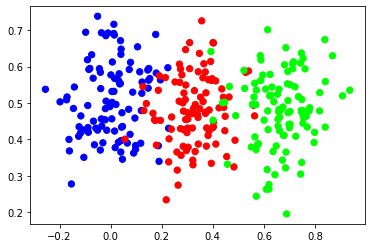

In [5]:
#SIMPLER DATASET
nnfs.init()
X, y = vertical_data(samples=100, classes=3)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap='brg')
plt.show()

# Test Strategy 1: Randomly Select Weights and Biases
For a large number of tests, randomly set weights and biases and look at accuracy.

In [ ]:
# Create dataset
X, Y = vertical_data(samples=100, classes=3)

# Create model
dense1 = Layer_Dense(2, 3) # first dense layer, 2 inputs, 3 neurons
activation1 = Activation_ReLU()
dense2 = Layer_Dense(3, 3) # second dense layer, 3 inputs, 3 neurons
activation2 = Activation_Softmax()

# Create loss function
loss_function = Loss_CategoricalCrossEntropy()

# Helper variables
lowest_loss = 9999999 # some initial value
best_dense1_weights = dense1.weights.copy()
best_dense1_biases = dense1.biases.copy()
best_dense2_weights = dense2.weights.copy()
best_dense2_biases = dense2.biases.copy()

for iteration in range(10000):
 # Generate a new set of weights for iteration
 dense1.weights = 0.05 * np.random.randn(2, 3)
 dense1.biases = 0.05 * np.random.randn(1, 3)
 dense2.weights = 0.05 * np.random.randn(3, 3)
 dense2.biases = 0.05 * np.random.randn(1, 3)
 
 # Perform a forward pass of the training data through this layer
 dense1.forward(X)
 activation1.forward(dense1.output)
 dense2.forward(activation1.output)
 activation2.forward(dense2.output)

 # Perform a forward pass through activation function
 # it takes the output of second dense layer here and returns loss
 loss = loss_function.calculate(activation2.output, Y)

 # Calculate accuracy from output of activation2 and targets
 # calculate values along first axis
 predictions = np.argmax(activation2.output, axis=1)
 accuracy = np.mean(predictions == Y)

 # If loss is smaller - print and save weights and biases aside
 if loss < lowest_loss:
   print('New set of weights found, iteration:', iteration,'loss:', loss, 'acc:', accuracy)
   best_dense1_weights = dense1.weights.copy()
   best_dense1_biases = dense1.biases.copy()
   best_dense2_weights = dense2.weights.copy()
   best_dense2_biases = dense2.biases.copy()
   lowest_loss = loss

New set of weights found, iteration: 0 loss: 1.0986564 acc: 0.3333333333333333
New set of weights found, iteration: 3 loss: 1.098138 acc: 0.3333333333333333
New set of weights found, iteration: 117 loss: 1.0980115 acc: 0.3333333333333333
New set of weights found, iteration: 124 loss: 1.0977516 acc: 0.6
New set of weights found, iteration: 165 loss: 1.097571 acc: 0.3333333333333333
New set of weights found, iteration: 552 loss: 1.0974693 acc: 0.34
New set of weights found, iteration: 778 loss: 1.0968257 acc: 0.3333333333333333
New set of weights found, iteration: 4307 loss: 1.0965533 acc: 0.3333333333333333
New set of weights found, iteration: 4615 loss: 1.0964499 acc: 0.3333333333333333
New set of weights found, iteration: 9450 loss: 1.0964295 acc: 0.3333333333333333


# Test Strategy 2: Randomly Adjust Weights and Biases
For a large number of tests with a starting weight and bias, update the weights and biases by some small, random value. If the new accuracy is higher, keep the weights and biases. If the new accuracy is lower, revert back to the last weights and biases.

In [ ]:
# Create dataset
X, Y = vertical_data(samples=100, classes=3)

# Create model
dense1 = Layer_Dense(2, 3) # first dense layer, 2 inputs
activation1 = Activation_ReLU()
dense2 = Layer_Dense(3, 3) # second dense layer, 3 inputs, 3 outputs
activation2 = Activation_Softmax()

# Create loss function
loss_function = Loss_CategoricalCrossEntropy()

# Helper variables
lowest_loss = 9999999 # some initial value
best_dense1_weights = dense1.weights.copy()
best_dense1_biases = dense1.biases.copy()
best_dense2_weights = dense2.weights.copy()
best_dense2_biases = dense2.biases.copy()

for iteration in range(10000):
 # Update weights with some small random values
 dense1.weights += 0.05 * np.random.randn(2, 3)
 dense1.biases += 0.05 * np.random.randn(1, 3)
 dense2.weights += 0.05 * np.random.randn(3, 3)
 dense2.biases += 0.05 * np.random.randn(1, 3)

 # Perform a forward pass of our training data through this layer
 dense1.forward(X)
 activation1.forward(dense1.output)
 dense2.forward(activation1.output)
 activation2.forward(dense2.output)

 # Perform a forward pass through activation function
 # it takes the output of second dense layer here and returns loss
 loss = loss_function.calculate(activation2.output, Y)

 # Calculate accuracy from output of activation2 and targets
 # calculate values along first axis
 predictions = np.argmax(activation2.output, axis=1)
 accuracy = np.mean(predictions == Y)

 # If loss is smaller - print and save weights and biases aside
 if loss < lowest_loss:
  print('New set of weights found, iteration:', iteration,'loss:', loss, 'acc:', accuracy)
  best_dense1_weights = dense1.weights.copy()
  best_dense1_biases = dense1.biases.copy()
  best_dense2_weights = dense2.weights.copy()
  best_dense2_biases = dense2.biases.copy()
  lowest_loss = loss
 # Revert weights and biases
 else:
  dense1.weights = best_dense1_weights.copy()
  dense1.biases = best_dense1_biases.copy()
  dense2.weights = best_dense2_weights.copy()
  dense2.biases = best_dense2_biases.copy()

New set of weights found, iteration: 0 loss: 1.1004413 acc: 0.3333333333333333
New set of weights found, iteration: 1 loss: 1.1003714 acc: 0.3333333333333333
New set of weights found, iteration: 2 loss: 1.0999109 acc: 0.3333333333333333
New set of weights found, iteration: 6 loss: 1.098478 acc: 0.3333333333333333
New set of weights found, iteration: 7 loss: 1.0979133 acc: 0.3333333333333333
New set of weights found, iteration: 10 loss: 1.0962688 acc: 0.3333333333333333
New set of weights found, iteration: 11 loss: 1.0956886 acc: 0.3333333333333333
New set of weights found, iteration: 18 loss: 1.0933328 acc: 0.3333333333333333
New set of weights found, iteration: 27 loss: 1.0928771 acc: 0.3333333333333333
New set of weights found, iteration: 35 loss: 1.0894114 acc: 0.64
New set of weights found, iteration: 38 loss: 1.0819336 acc: 0.6666666666666666
New set of weights found, iteration: 42 loss: 1.0804778 acc: 0.5866666666666667
New set of weights found, iteration: 48 loss: 1.0791433 acc:

# Test Strategy 2 on Spiral Dataset

In [ ]:
# Create dataset
X, Y = spiral_data(samples=100, classes=3)

# Create model
dense1 = Layer_Dense(2, 3) # first dense layer, 2 inputs
activation1 = Activation_ReLU()
dense2 = Layer_Dense(3, 3) # second dense layer, 3 inputs, 3 outputs
activation2 = Activation_Softmax()

# Create loss function
loss_function = Loss_CategoricalCrossEntropy()

# Helper variables
lowest_loss = 9999999 # some initial value
best_dense1_weights = dense1.weights.copy()
best_dense1_biases = dense1.biases.copy()
best_dense2_weights = dense2.weights.copy()
best_dense2_biases = dense2.biases.copy()

for iteration in range(10000):
 # Update weights with some small random values
 dense1.weights += 0.05 * np.random.randn(2, 3)
 dense1.biases += 0.05 * np.random.randn(1, 3)
 dense2.weights += 0.05 * np.random.randn(3, 3)
 dense2.biases += 0.05 * np.random.randn(1, 3)

 # Perform a forward pass of our training data through this layer
 dense1.forward(X)
 activation1.forward(dense1.output)
 dense2.forward(activation1.output)
 activation2.forward(dense2.output)

 # Perform a forward pass through activation function
 # it takes the output of second dense layer here and returns loss
 loss = loss_function.calculate(activation2.output, Y)

 # Calculate accuracy from output of activation2 and targets
 # calculate values along first axis
 predictions = np.argmax(activation2.output, axis=1)
 accuracy = np.mean(predictions == Y)

 # If loss is smaller - print and save weights and biases aside
 if loss < lowest_loss:
  print('New set of weights found, iteration:', iteration,'loss:', loss, 'acc:', accuracy)
  best_dense1_weights = dense1.weights.copy()
  best_dense1_biases = dense1.biases.copy()
  best_dense2_weights = dense2.weights.copy()
  best_dense2_biases = dense2.biases.copy()
  lowest_loss = loss
 # Revert weights and biases
 else:
  dense1.weights = best_dense1_weights.copy()
  dense1.biases = best_dense1_biases.copy()
  dense2.weights = best_dense2_weights.copy()
  dense2.biases = best_dense2_biases.copy()

New set of weights found, iteration: 0 loss: 1.0990145 acc: 0.3333333333333333
New set of weights found, iteration: 2 loss: 1.0988153 acc: 0.33666666666666667
New set of weights found, iteration: 6 loss: 1.0986578 acc: 0.3333333333333333
New set of weights found, iteration: 10 loss: 1.0986433 acc: 0.3333333333333333
New set of weights found, iteration: 18 loss: 1.098215 acc: 0.3333333333333333
New set of weights found, iteration: 37 loss: 1.0981511 acc: 0.3333333333333333
New set of weights found, iteration: 39 loss: 1.0980632 acc: 0.37666666666666665
New set of weights found, iteration: 41 loss: 1.0969162 acc: 0.3566666666666667
New set of weights found, iteration: 42 loss: 1.096638 acc: 0.3333333333333333
New set of weights found, iteration: 44 loss: 1.0957416 acc: 0.3433333333333333
New set of weights found, iteration: 59 loss: 1.0945884 acc: 0.3333333333333333
New set of weights found, iteration: 60 loss: 1.0926462 acc: 0.3566666666666667
New set of weights found, iteration: 61 los